# Reconstruction of static Europe climate data
_Author_: __Jakub Walczak__

_Goal_: The goal of these experiments is to evaluate and compare the common climate data reconstruction methods (IDW and kriging) with deep learning methods relying on Implicit Neural Representation (INR).

_Methods_: 
1. Inwerse Distance Weightining (IDW),
2. Ordinary kriging,
3. Implicit Neural Representation with periodic activation function (SIREN).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import climatrix as cm

In [2]:
EXP_DIR = Path("./results")
EXP_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
N_BINS = 40
HIST_RANGE = (-10.0, 10)

In [4]:
def plot(comp):
    fig, ax = plt.subplots(1, 2, figsize=(24, 10))
    comp.plot_diff(ax=ax[0])
    comp.plot_signed_diff_hist(ax=ax[1], n_bins=N_BINS, limits=HIST_RANGE)    

### 1. Subset static temperature data for Europe

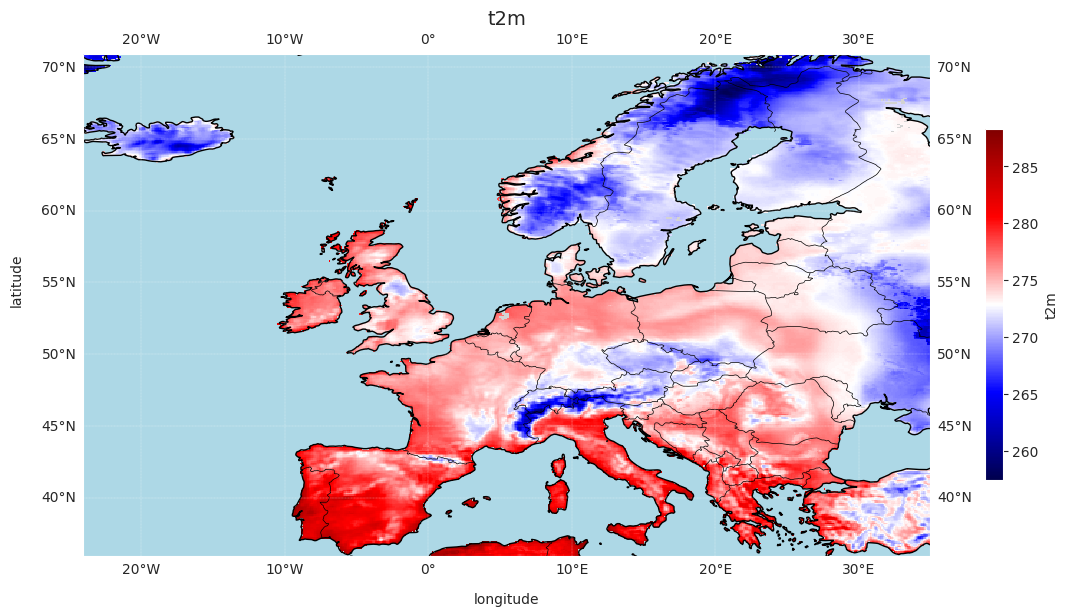

In [5]:
dset = xr.open_dataset("../../data/era5-land.nc").cm
europe = dset.subset(north=71, south=36, west=-24, east=35).isel_time(0)
europe.plot();

## 2. Sample uniformly $N$ points

Loading sparse dataset...


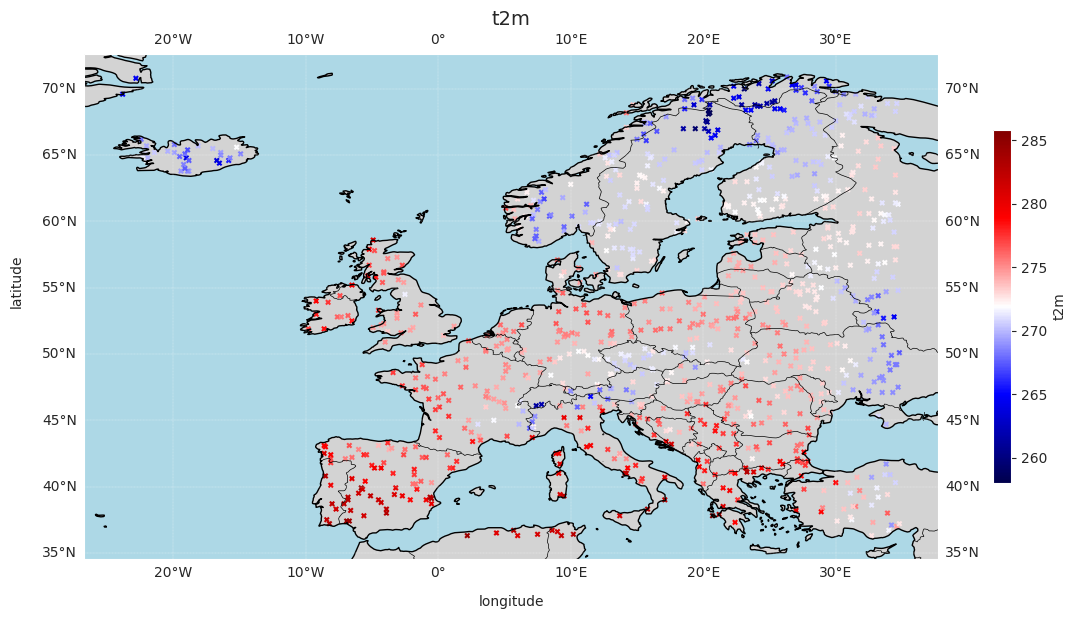

In [6]:
sparse_file = EXP_DIR / "sparse.nc"
if sparse_file.exists():
    print("Loading sparse dataset...")
    sparse = xr.open_dataset(sparse_file).cm
else:
    print("Sampling dataset...")
    sparse = europe.sample(number=1_000, kind="uniform", nan_policy="resample")
    sparse.da.to_netcdf(sparse_file)
sparse.plot();

## 3a. Reconstruct with IDW

02-04-2025 13:02:50 INFO | climatrix.reconstruct.idw | Reconstructing static dataset...


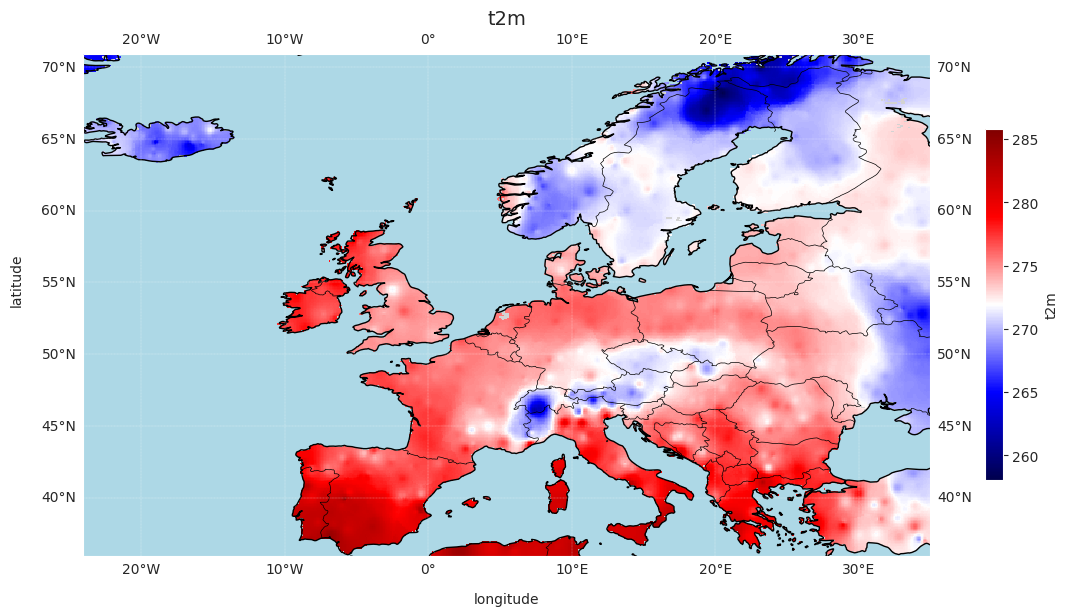

In [7]:
idw_dense = sparse.reconstruct(europe.domain, method="idw", k=10)
idw_dense = idw_dense.mask_nan(europe)
idw_dense.plot();

In [ ]:
idw_comp = cm.Comparison(predicted_dataset=idw_dense, true_dataset=europe)
idw_comp.save_report(EXP_DIR / "idw")

/storage/tul/projects/climatrix/src/climatrix/comparison.py:202: UserWarning: The target directory already exists and will be overwritten.
  warnings.warn(


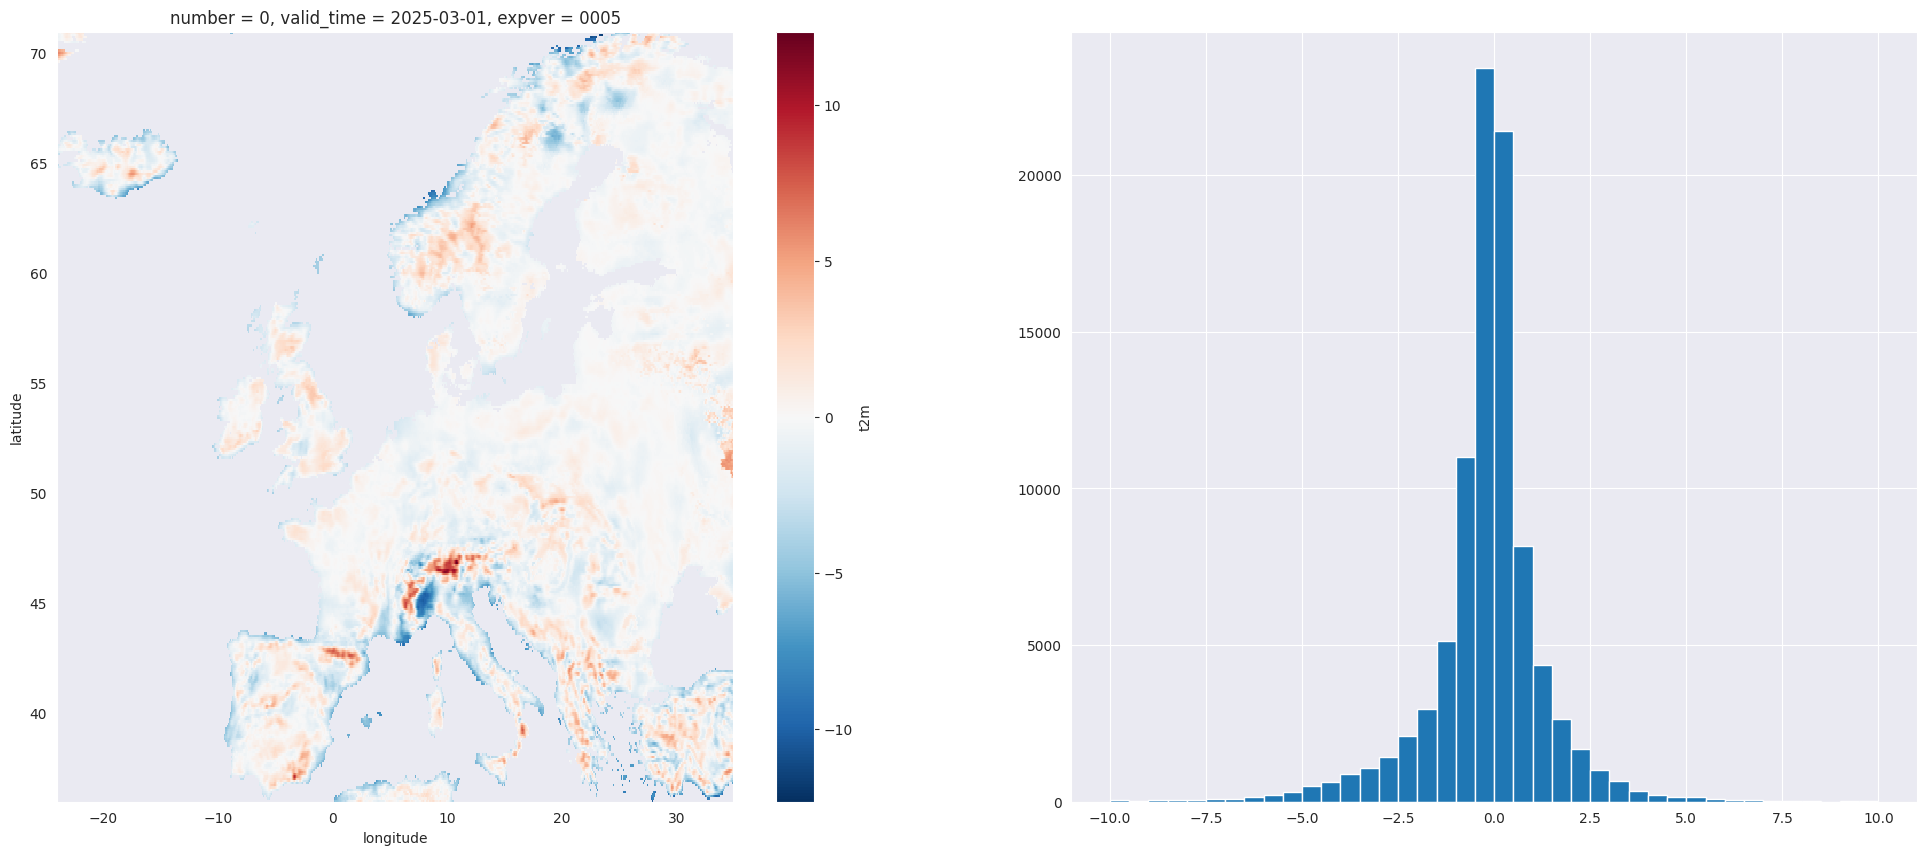

In [9]:
plot(idw_comp);

## 3b. Reconstruction with Ordinary Kriging

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'linear' Variogram Model
Slope: 0.8151680166415458
Nugget: 3.0928058185946474 

Calculating statistics on variogram model fit...
02-04-2025 13:08:52 INFO | climatrix.reconstruct.kriging | Performing Ordinary Kriging reconstruction...
Executing Ordinary Kriging...



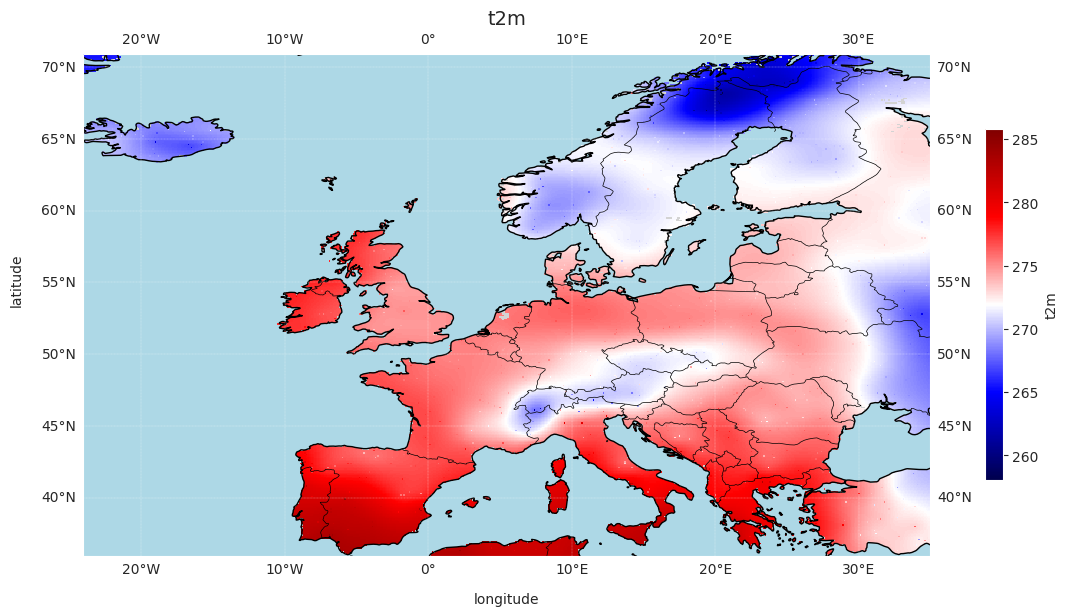

In [19]:
ok_dense = sparse.reconstruct(europe.domain, method="ok", verbose=True, backend="vectorize")
ok_dense = ok_dense.mask_nan(europe)
ok_dense.plot();

In [ ]:
ok_comp = cm.Comparison(predicted_dataset=ok_dense, true_dataset=europe)
ok_comp.save_report(EXP_DIR / "ok")

/storage/tul/projects/climatrix/src/climatrix/comparison.py:202: UserWarning: The target directory already exists and will be overwritten.
  warnings.warn(


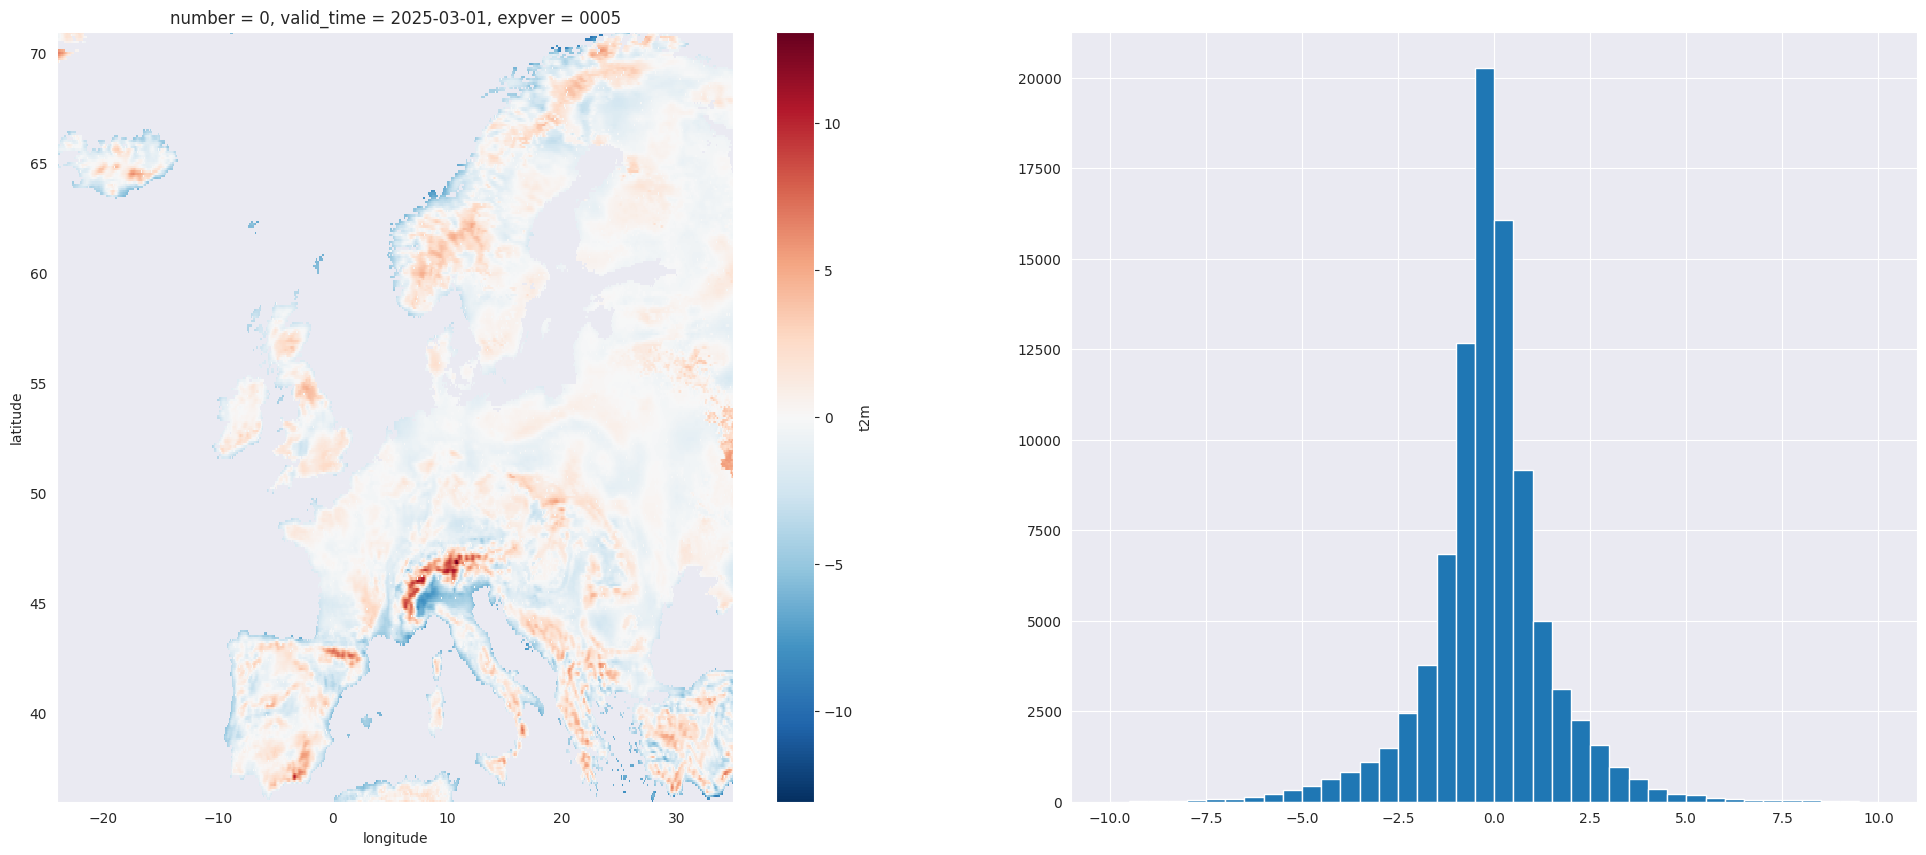

In [21]:
plot(ok_comp);

## 3c. Reconstruction with SIREN

In [13]:
checkpoint = EXP_DIR / "siren.ckpt"

In [14]:
siren_dense = sparse.reconstruct(europe.domain, method="siren", checkpoint=checkpoint)

02-04-2025 13:04:45 INFO | climatrix.reconstruct.siren.siren | Using checkpoint path: /storage/tul/projects/climatrix/experiments/jwalczak/results/siren.ckpt
02-04-2025 13:04:45 INFO | climatrix.reconstruct.siren.siren | Initializing SIREN model...
02-04-2025 13:04:45 INFO | climatrix.reconstruct.siren.siren | Loading checkpoint from /storage/tul/projects/climatrix/experiments/jwalczak/results/siren.ckpt...
02-04-2025 13:04:46 INFO | climatrix.reconstruct.siren.siren | Creating mini-batches for surface reconstruction...
02-04-2025 13:04:46 INFO | climatrix.reconstruct.siren.siren | Processing mini-batch 1/1...


ValueError: cannot reshape array of size 1000 into shape (350,590)

In [ ]:
siren_comp = cm.Comparison(predicted_dataset=siren_dense, true_dataset=europe)
siren_comp.save_report(EXP_DIR / "siren")

In [ ]:
plot(siren_comp);

## 4. Comparison of histograms

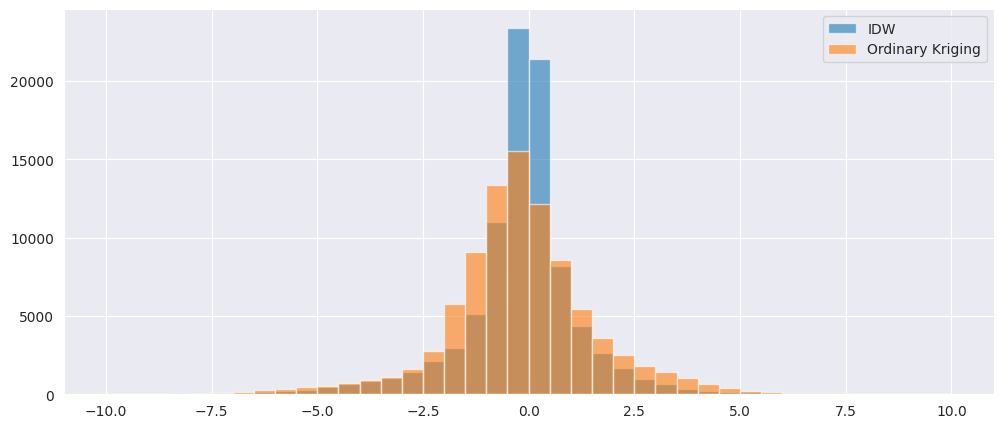

In [18]:
fig, ax = plt.subplots(figsize=(12, 5))
idw_comp.plot_signed_diff_hist(ax=ax, n_bins=N_BINS, limits=HIST_RANGE, alpha=0.6, label="IDW")    
ok_comp.plot_signed_diff_hist(ax=ax, n_bins=N_BINS, limits=HIST_RANGE, alpha=0.6, label="Ordinary Kriging")    
# siren_comp.plot_signed_diff_hist(ax=ax, n_bins=N_BINS, limits=HIST_RANGE, alpha=0.6)    
ax.legend()